In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import classification as classify
import imbalanced as imb
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import statistics
data = classify.load_data("data_for_student_case.csv")

from sklearn.ensemble import RandomForestClassifier
from subprocess import call
from IPython.display import Image
from six import StringIO  
from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib as mpl
import pylab as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
pdata = classify.pre_process(data)
classify.describe_data(pdata)

pdata.head()

Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%



,txid,issuercountrycode,bin,amount,shoppercountrycode,simple_journal,mail_id,ip_id,card_id,txvariantcode_electron,...,shopperinteraction_Ecommerce,shopperinteraction_POS,cvcresponsecode_0,cvcresponsecode_1,cvcresponsecode_2,cvcresponsecode_3,accountcode_APACAccount,accountcode_MexicoAccount,accountcode_SwedenAccount,accountcode_UKAccount
0,1.0,76.0,530056.0,0.0,98.0,1.0,187702.0,7386.0,73358.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2.0,76.0,547046.0,0.0,98.0,1.0,834.0,194109.0,44739.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3.0,76.0,528843.0,0.0,98.0,1.0,119287.0,189655.0,122802.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4.0,76.0,547146.0,0.0,98.0,1.0,173561.0,8254.0,70712.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,76.0,477291.0,0.0,98.0,1.0,70647.0,196247.0,208481.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,issuercountrycode,txvariantcode,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cvcresponsecode,accountcode,mail_id,ip_id,card_id
0,76.0,2.0,0.0,2.0,98.0,0.0,1.0,0.0,1.0,187702.0,7386.0,73358.0
1,76.0,2.0,0.0,2.0,98.0,0.0,1.0,0.0,1.0,834.0,194109.0,44739.0
2,76.0,2.0,0.0,2.0,98.0,0.0,1.0,0.0,1.0,119287.0,189655.0,122802.0
3,76.0,2.0,0.0,2.0,98.0,0.0,1.0,0.0,1.0,173561.0,8254.0,70712.0
4,76.0,6.0,0.0,2.0,98.0,0.0,1.0,0.0,1.0,70647.0,196247.0,208481.0


In [4]:
pdata = classify.pre_process(data)
classify.describe_data(pdata)

Total: 237036
Non-Fraud: 236691 = 99.8545%
Fraud: 345 = 0.1455%



0 68888 8611 13 124
1 68888 8611 6 89
2 68888 8611 10 93
3 68888 8611 10 97
4 68888 8611 7 110
5 69111 8638 13 98
6 69111 8638 8 79
7 69111 8638 12 95
8 69111 8638 12 81
9 69111 8638 8 97
White-box TP: 105
White-box FP: 1739
Black-box TP: 99
Black-box FP: 963


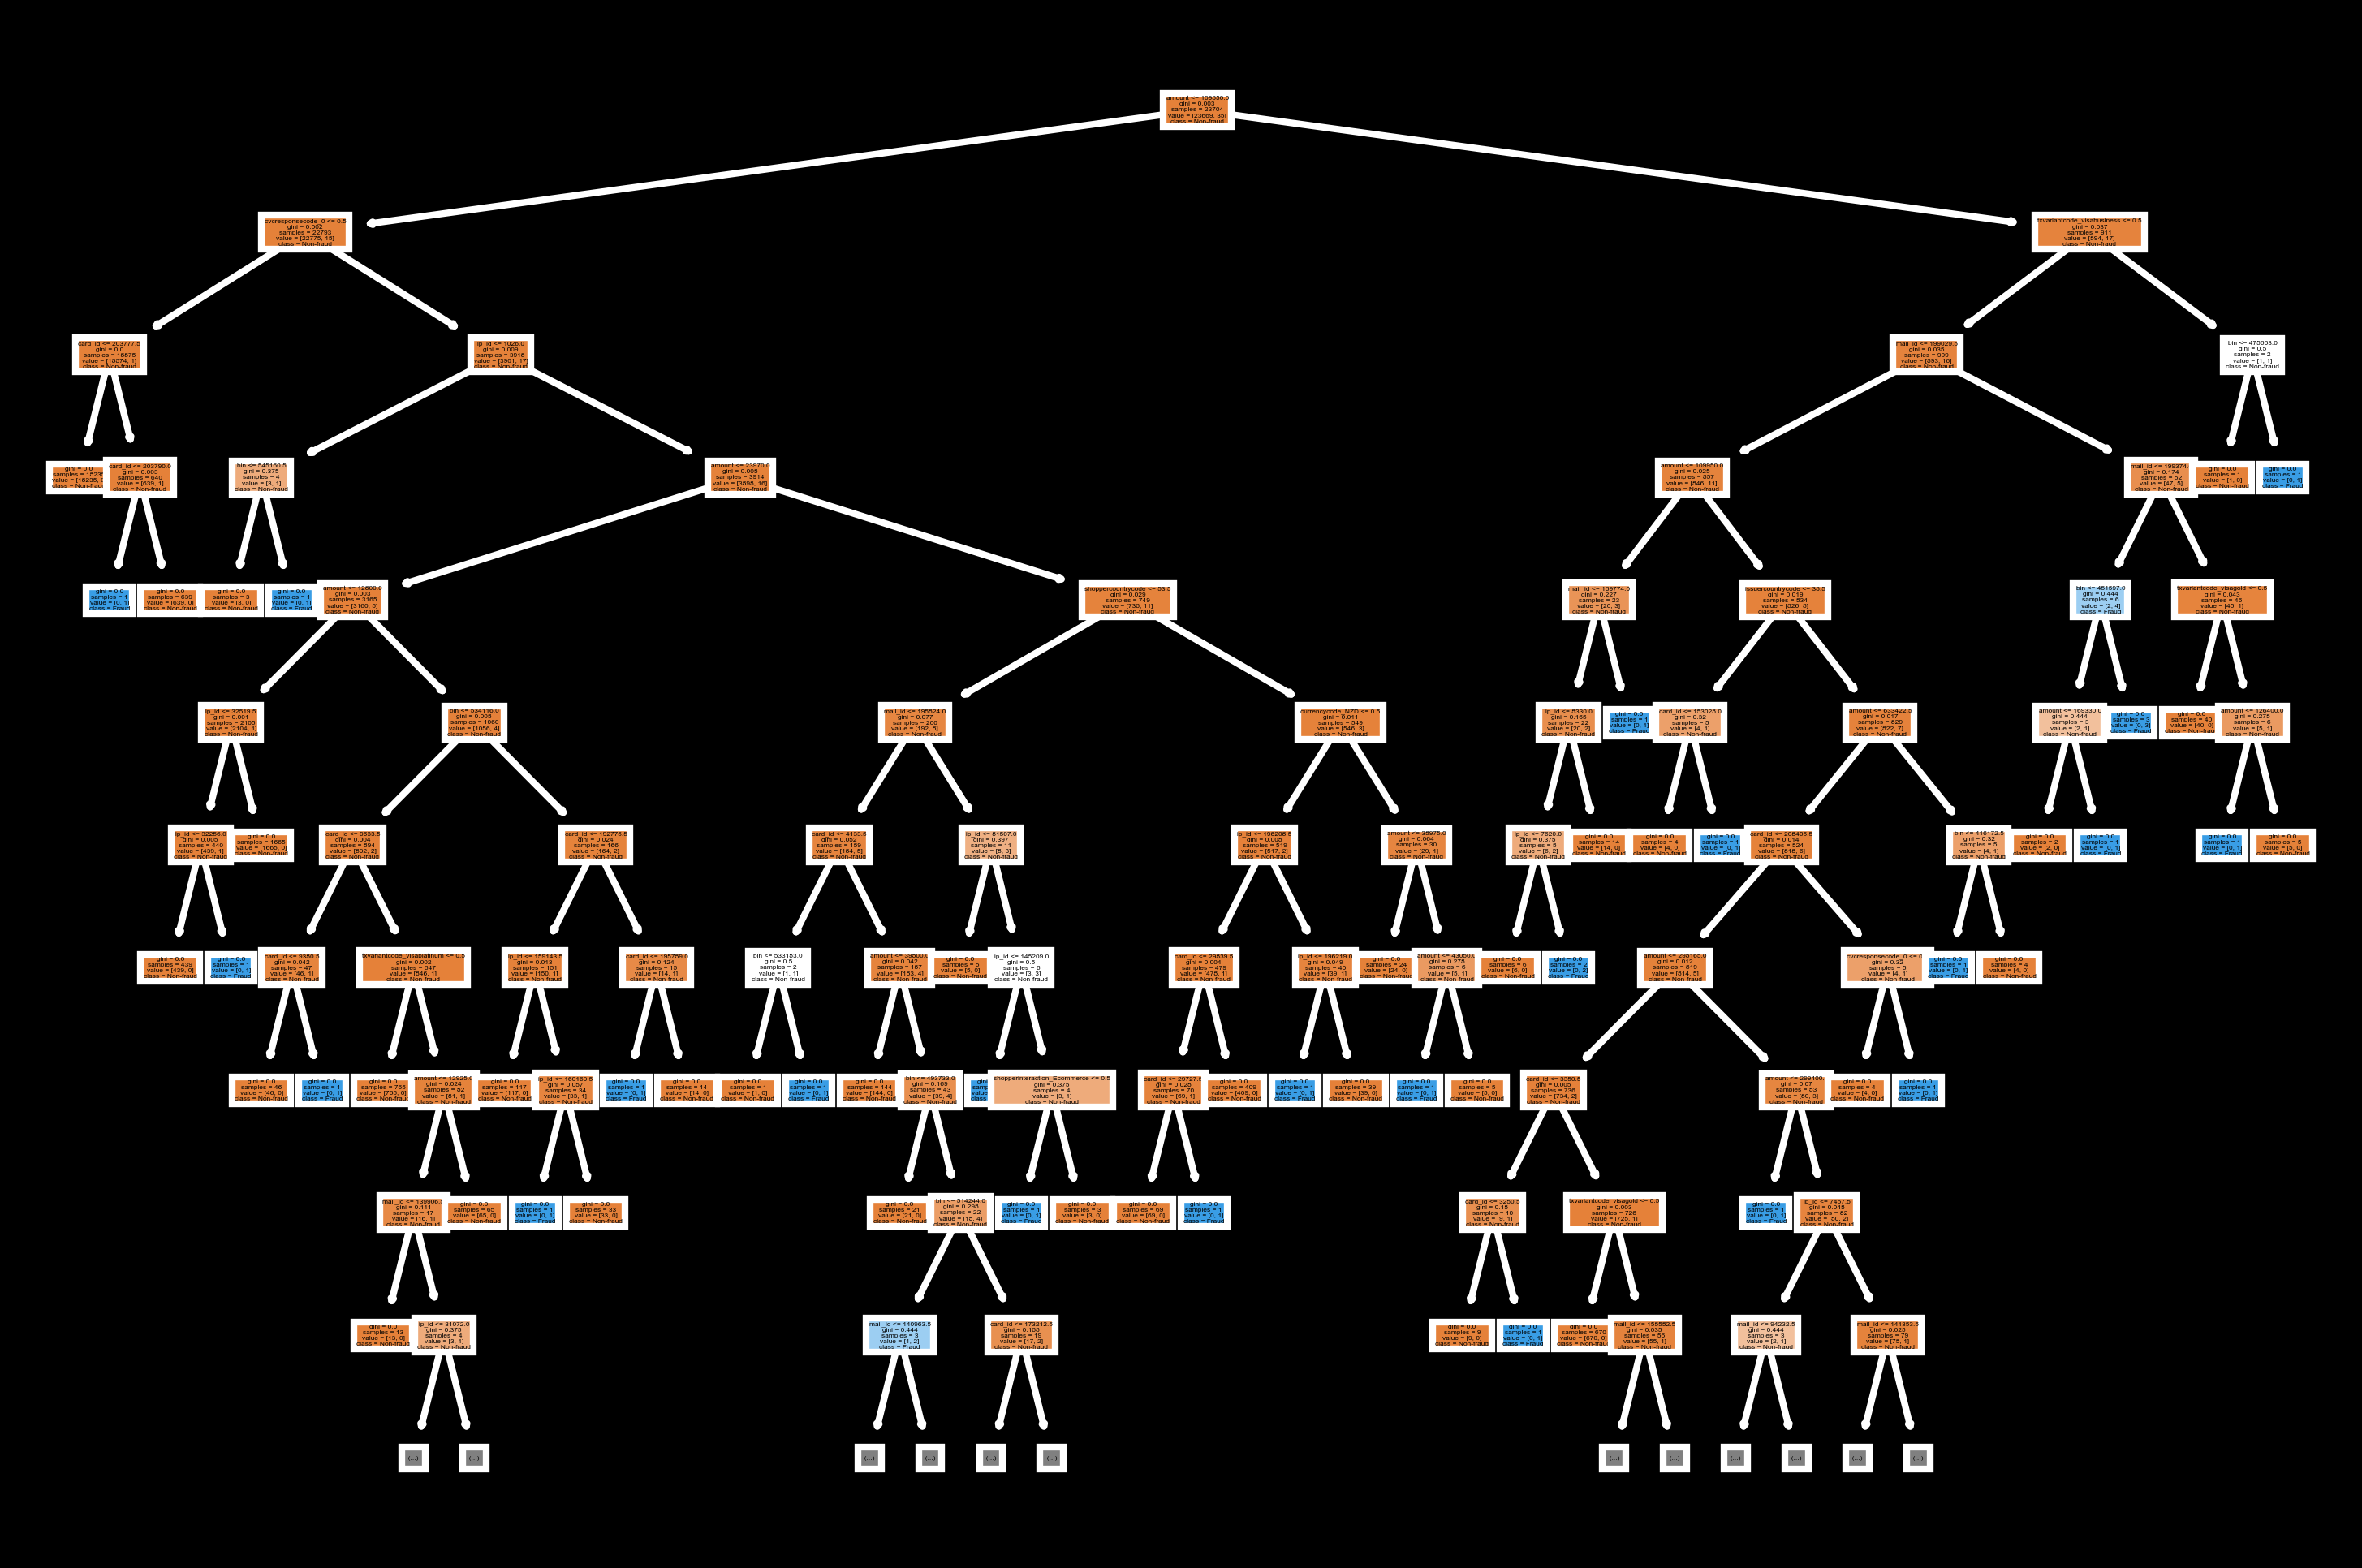

In [ ]:
random_state=13
under_sampling_rate=0.0045
over_sampling_rate=0.125
splits = 10

# Get feature vector and truth vector from dataset
X, y = imb.get_X_y(pdata)

# cv = KFold(n_splits=splits, shuffle=True)
cv = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state)

tp_wb_total = []
tp_bb_total = []
fp_wb_total = []
fp_bb_total = []
feature_importance = np.zeros(pdata.shape[1])
iteration = 0
targets = ['Non-fraud', 'Fraud']

for train_index, test_index in cv.split(X,y):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    # Undersampling non-fraud class
    under_sampling = RandomUnderSampler(sampling_strategy=under_sampling_rate)
    X_train, y_train = under_sampling.fit_sample(X_train,y_train)
    
    # SMOTE Re-sampling
    sm = SMOTE(sampling_strategy=over_sampling_rate, random_state=random_state)

    X_train, y_train = sm.fit_sample(X_train, y_train)

    # Decision Tree classifer (White-Box)
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    tp_wb_total.append(TP)
    fp_wb_total.append(FP)
    
    importances = clf.feature_importances_
    for i in range(len(X_train.columns)):
        feature_importance[i] += importances[i]

    # Decision Tree Decider
    plt.style.use('dark_background')  
    mpl.rcParams['text.color'] = 'black'
    
    fig, ax = plt.subplots(dpi=600)
    tree.plot_tree(clf.fit(X_test,y_test),max_depth=10,feature_names = X_train.columns, class_names=targets,filled = True, rotate=True, ax=ax)
    fig.savefig('tree-'+str(iteration)+'.png')

    # RandomForest Classifier (Black-box)
    clf = RandomForestClassifier(random_state=random_state, n_estimators=50,max_depth=30,min_samples_leaf=5,min_samples_split=12,n_jobs=2)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    tp_bb_total.append(TP)
    fp_bb_total.append(FP)
    
    print(iteration, len(y_train[y_train==0]),len(y_train[y_train==1]), TP, FP)
    iteration += 1 
    
print(f"White-box TP: {np.sum(tp_wb_total)}")
print(f"White-box FP: {np.sum(fp_wb_total)}")
print(f"Black-box TP: {np.sum(tp_bb_total)}")
print(f"Black-box FP: {np.sum(fp_bb_total)}")

In [ ]:
# Plot feature importance
features = X_train.columns.values
feat_imp = feature_importance[0:len(features)-1]

idx   = np.argsort(feat_imp)
imp = np.array(feat_imp)[idx]
features = np.array(features)[idx]

print(features)
print(imp)

f, ax = plt.subplots(1,figsize = (100,8))
ax = sns.barplot(x=features,y=imp)
plt.show()

###############
0.005 (62K) - 0.125 (7.7K) random_state: 33
White-box TP: 75
White-box FP: 1842
Black-box TP: 62
Black-box FP: 596

0.0075 (41K) - 0.125 (5.2K) random_state: 33
White-box TP: 84
White-box FP: 2479
Black-box TP: 70
Black-box FP: 779
    
0.00875 (35K) - 0.125 (4.4K) random_state: 33
White-box TP: 83
White-box FP: 2763
Black-box TP: 67
Black-box FP: 855

0.01 (31K) - 0.125 (3.8K) random_state: 33
White-box TP: 90
White-box FP: 3069
Black-box TP: 66
Black-box FP: 950
    
###############
0.005 (62K) - 0.125 (7.7K) random_state: 42
White-box TP: 70
White-box FP: 1759
Black-box TP: 66
Black-box FP: 584

0.0075 (41K) - 0.125 (5.2K) random_state: 42
White-box TP: 85
White-box FP: 2505
Black-box TP: 65
Black-box FP: 754
    
0.00875 (35K) - 0.125 (4.4K) random_state: 42
White-box TP: 84
White-box FP: 2761
Black-box TP: 66
Black-box FP: 855    


0.0015 (206K) - 0.125 (25K) random_state: 13
White-box TP: 58
White-box FP: 716
Black-box TP: 49
Black-box FP: 252
    
0.0015 (206K) - 0.125 (25K) random_state: 13, with threshold=0.6 post-processing
White-box TP: 59
White-box FP: 703
Black-box TP: 46
Black-box FP: 153

0.002 (155K) - 0.125 (19K) random_state: 13
White-box TP: 71
White-box FP: 692
Black-box TP: 50
Black-box FP: 220

0.0025 (124K) - 0.125 (15K) random_state: 13
White-box TP: 77
White-box FP: 935
Black-box TP: 65
Black-box FP: 308

0.005 (62K) - 0.125 (7.7K) random_state: 13
White-box TP: 91
White-box FP: 1473
Black-box TP: 78
Black-box FP: 533

0.0075 (41K) - 0.125 (5.2K) random_state: 13
White-box TP: 108 / 84
White-box FP: 2104 / 2321
Black-box TP: 92 / 62
Black-box FP: 699 / 747
        
0.00875 (35K) - 0.125 (4.4K) random_state: 13
White-box TP: 97
White-box FP: 2443
Black-box TP: 84
Black-box FP: 756
        
0.01 (31K) - 0.125 (3.8K) random_state: 13
White-box TP: 98 / 89
White-box FP: 2524 / 2735
Black-box TP: 92 / 67
Black-box FP: 919 / 853
    
0.01 (31K) - 0.125 (3.8K) random_state: 13, with threshold=0.6 post-processing
White-box TP: 95
White-box FP: 2922
Black-box TP: 57
Black-box FP: 501

0.0125 (25K) - 0.125 (3.1K) random_state: 13
White-box TP: 95
White-box FP: 3498
Black-box TP: 78
Black-box FP: 1126

0.002 (155K) - 0.2 (31K) random_state: 13
White-box TP: 59
White-box FP: [75, 79, 104, 74, 98, 87, 77, 73, 80, 80], SUM: 827
Black-box TP: [11, 2, 5, 7, 4, 6, 4, 4, 3, 6], SUM: 52
Black-box FP: [41, 30, 39, 31, 34, 43, 32, 35, 31, 37], SUM: 353
    
0.0025 (124K) - 0.2 (25K) random_state: 13
White-box TP: [10, 3, 7, 9, 5, 7, 7, 6, 7, 6], SUM: 67
White-box FP: [113, 111, 120, 97, 117, 112, 103, 102, 84, 111], SUM: 1070
Black-box TP: [11, 2, 5, 10, 4, 7, 4, 4, 4, 6], SUM: 57
Black-box FP: [33, 40, 42, 34, 55, 49, 39, 42, 40, 50], SUM: 424
        
0.005 (62K) - 0.2 (12K) random_state: 13
White-box TP: [10, 4, 10, 11, 6, 8, 6, 6, 6, 9], SUM: 76
White-box FP: [217, 164, 202, 185, 187, 187, 192, 183, 137, 158], SUM: 1812
Black-box TP: [11, 3, 6, 9, 5, 7, 4, 7, 3, 6], SUM: 61
Black-box FP: [70, 66, 54, 59, 77, 79, 60, 74, 71, 76], SUM: 686

0.0075 (41K) - 0.2 (8.2K) random_state: 13
White-box TP: [12, 6, 6, 9, 8, 8, 10, 8, 6, 9], SUM: 82
White-box FP: [249, 246, 260, 226, 252, 254, 233, 262, 243, 270], SUM: 2495
Black-box TP: [11, 2, 6, 10, 7, 7, 6, 6, 4, 8], SUM: 67
Black-box FP: [91, 93, 80, 89, 121, 102, 85, 90, 81, 111], SUM: 943       
        
0.00875 (35K) - 0.2 (7.1K) random_state: 13
White-box TP: [13, 10, 9, 8, 8, 10, 11, 7, 7, 8], SUM: 91
White-box FP: [267, 312, 248, 258, 284, 271, 261, 284, 296, 259], SUM: 2740
Black-box TP: [12, 3, 7, 10, 6, 9, 6, 8, 4, 8], SUM: 73
Black-box FP: [101, 111, 98, 84, 125, 113, 100, 99, 108, 110], SUM: 1049
        
0.01 (31K) - 0.2 (6.2K) random_state: 13
White-box TP: [11, 3, 8, 12, 9, 8, 11, 8, 7, 10], SUM: 87
White-box FP: [301, 299, 273, 288, 324, 348, 343, 320, 314, 290], SUM: 3100
Black-box TP: [11, 3, 6, 11, 6, 9, 6, 6, 4, 10], SUM: 72
Black-box FP: [118, 120, 115, 116, 136, 125, 100, 119, 97, 130], SUM: 1176

In [ ]:
0.01 (31K) - 0.1 (3.1K) random_state: 13
White-box TP: 83
White-box FP: 2764
Black-box TP: 70
Black-box FP: 818    
    
0.01 (31K) - 0.1 (3.1K) random_state: 13, with threshold=0.65 post-processing
White-box TP: 86
White-box FP: 2914
Black-box TP: 50
Black-box FP: 324